In [134]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly import tools
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [136]:
# fetching numerical data
df_n = pd.read_csv("data/clustering_data.csv",index_col=0)

Removing numerical features that turned out to be identical
From EDA and clustering quite a few features were found to have similarity. From that analysis, let's remove the similar
features to avoid the problem of overfitting and multicollinearity. Features B_15, B_17 and B_19 were similar in nature,
hence, removing the former two (on the basis of higher similarity). Similarly, among features B_24, B_25 and B_16, dropping
the former two features.

drop 15 and 17

drop 16 and 25

In [137]:
df_n.drop(columns=['B_15','B_17','B_24','B_25'],inplace=True)

In [138]:
# reading in categorical data along with labels
df_c = pd.read_csv("data/cleaned_data.csv")[['B_3','B_10','B_21','Good/Bad']]

In [139]:
# converting categorical features into characters
df_c = df_c.astype(str)

In [140]:
df_c.B_3.value_counts()

-0.0003      2026
0.0001       2017
0.0          2011
0.0003       1979
-0.0004      1975
0.0002       1957
-0.0001      1948
-0.0002      1947
0.0004       1919
0.0005       1032
-0.0005       930
-0.000303     389
0.0006         69
-0.0006        33
Name: B_3, dtype: int64

In [141]:
df_c.B_21.value_counts()

393.0     5213
392.0     4419
394.0     3922
395.0     2254
391.0     1938
396.0     1136
390.0      432
397.0      422
396.93     390
398.0       67
389.0       30
399.0        7
388.0        1
400.0        1
Name: B_21, dtype: int64

Categorical feature selection:

1. Chi-Squared: Chi-Square Goodness of Fit Test (to check if predictor is correlated with target) and Chi-Square Test of Independence ( test if two variables might be correlated or not ).

2. Mutual Information gain: It measures the average reduction in uncertainty about y that results from learning the value of x, or vice-versa. Mutual Information and Information Gain are the same thing, although the context or usage of the measure often gives rise to the different names. Notice the similarity in the way that the mutual information is calculated and the way that information gain is calculated. In information gain, we calculate the difference in the value of entropy, given a particular split. This is same as calculating the reduction in randomness given a value of random variable.

In [142]:
def chi2_by_hand(df, col1, col2):    
    #---create the contingency table---
    df_cont = pd.crosstab(index = df[col1], columns = df[col2])
#     display(df_cont)
    #---calculate degree of freedom---
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    #---sum up the totals for row and columns---
    df_cont.loc[:,'Total']= df_cont.sum(axis=1)
    df_cont.loc['Total']= df_cont.sum()
#     print('---Observed (O)---')
#     display(df_cont)
    #---create the expected value dataframe---
    df_exp = df_cont.copy()    
    df_exp.iloc[:,:] = np.multiply.outer(
        df_cont.sum(1).values,df_cont.sum().values) / df_cont.sum().sum()            
#     print('---Expected (E)---')
#     display(df_exp)
        
    # calculate chi-square values
    df_chi2 = ((df_cont - df_exp)**2) / df_exp    
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1)
    df_chi2.loc['Total']= df_chi2.sum()
    
#     print('---Chi-Square---')
#     display(df_chi2)
    #---get chi-square score---   
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    return chi_square_score, degree_f, p

In [143]:
chi_score, dof, p = chi2_by_hand(df_c,'B_21','Good/Bad')
print(f'P-value: {p}, between Features B_21 Good/Bad')

chi_score, dof, p = chi2_by_hand(df_c,'B_10','Good/Bad')
print(f'P-value: {p}, between Features B_10 Good/Bad')

chi_score, dof, p = chi2_by_hand(df_c,'B_3','Good/Bad')
print(f'P-value: {p}, between Features B_3 Good/Bad')

P-value: 0.0, between Features B_21 Good/Bad
P-value: 7.217766909663927e-16, between Features B_10 Good/Bad
P-value: 0.2793139550652076, between Features B_3 Good/Bad


P-value for chi squared tests between categorical variables and the target variable enables us to determine if a predictor is having correlation with the target. Since the null hypothesis is that the two variables are independent, we can confirm that feature B_3 is not correlated with the target, and we shall remove it for prediction modelling.

In [144]:
chi_score, dof, p = chi2_by_hand(df_c,'B_21','B_10')
print(f'P-value: {p}, between Features B_21 B_10')

P-value: 1.1189587620285315e-81, between Features B_21 B_10


From the above test, we can confirm that the features B_21 and B_10 are dependent on each other, which indicates that keeping both of them in the model will trigger multicollieanrity. Hence removing one of them would be a plausible option for predictive modelling. Both the features have same p-value for the test so we cannot decide which one to drop on this basis. Hence,removing B_10 as it has less number of categories, or less amount of variation. 

In [145]:
df_c.drop(columns=['B_3','B_10'],inplace=True)

In [146]:
df_c.B_21[df_c.B_21.str.contains("|".join(list(df_c.B_21.value_counts().index[df_c.B_21.value_counts() < 100])))] = "imputed"

In [147]:
df_c.B_21.value_counts()

393.0      5213
392.0      4419
394.0      3922
395.0      2254
391.0      1938
396.0      1136
390.0       432
397.0       422
396.93      390
imputed     106
Name: B_21, dtype: int64

In [148]:
encoded_B21 = pd.get_dummies(df_c.B_21)

In [149]:
df_c = pd.concat([df_c.drop(columns=['B_21']),encoded_B21],axis=1)

In [150]:
df = pd.concat([df_n.reset_index(),df_c],axis=1)
df = df.set_index('timestamp',drop=True)

In [151]:
df.head()

,B_18,B_2,B_19,B_16,Good/Bad,390.0,391.0,392.0,393.0,394.0,395.0,396.0,396.93,397.0,imputed
timestamp,,,,,,,,,,,,,,,
2020-03-01 00:00:00,8138.62,-0.0007,8.4195,521.66,0,0,0,1,0,0,0,0,0,0,0
2020-03-01 00:05:00,8131.49,0.0019,8.4318,522.28,0,0,0,1,0,0,0,0,0,0,0
2020-03-01 00:10:00,8133.23,-0.0043,8.4178,522.42,0,1,0,0,0,0,0,0,0,0,0
2020-03-01 00:15:00,8133.83,0.0007,8.3682,522.86,0,0,0,1,0,0,0,0,0,0,0
2020-03-01 00:20:00,8133.80,-0.0019,8.4294,522.19,0,0,0,0,1,0,0,0,0,0,0


In [152]:
df.to_csv("./data/classification_1.csv")

In [153]:
Label = df['Good/Bad']
df.drop(columns=['Good/Bad'],inplace=True)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(df,Label,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [160]:
X_train.head(3)

,B_18,B_2,B_19,B_16,390.0,391.0,392.0,393.0,394.0,395.0,396.0,396.93,397.0,imputed
timestamp,,,,,,,,,,,,,,
2020-03-30 00:40:00,8132.36,0.00110,8.4260,521.60,0,1,0,0,0,0,0,0,0,0
2020-03-10 06:35:00,8162.62,0.00075,8.4628,520.95,0,0,0,0,0,1,0,0,0,0
2020-04-05 08:40:00,8127.79,0.00110,8.4428,521.83,0,0,1,0,0,0,0,0,0,0


In [161]:
y_train.head(3)

timestamp
2020-03-30 00:40:00    0
2020-03-10 06:35:00    0
2020-04-05 08:40:00    0
Name: Good/Bad, dtype: object

In [162]:
X_test.head(3)

,B_18,B_2,B_19,B_16,390.0,391.0,392.0,393.0,394.0,395.0,396.0,396.93,397.0,imputed
timestamp,,,,,,,,,,,,,,
2020-05-10 03:05:00,8150.50,0.0000,8.4212,521.590,0,0,0,0,0,1,0,0,0,0
2020-04-14 22:35:00,8134.87,-0.0003,8.4371,521.675,0,0,0,0,1,0,0,0,0,0
2020-04-21 19:50:00,8123.78,0.0004,8.5080,519.790,0,0,0,0,0,0,0,0,1,0


In [163]:
y_test.head(3)

timestamp
2020-05-10 03:05:00    0
2020-04-14 22:35:00    0
2020-04-21 19:50:00    1
Name: Good/Bad, dtype: object

In [205]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [20]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [165]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[0.93033631 0.92962582 0.93099897 0.92481977 0.93374528]


The aim is to reduce the False negatives (that is, it is falsely predicted that furnace do not require maintenance). At present this number is 117. Hence we shall try to reduce this number by tweaking some parameters of our decision tree.

In [166]:
def get_classification_analysis_dt(params):
    clf = DecisionTreeClassifier()
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    return clf

In [167]:
def tree_viz(clf):
    plt.figure(figsize=(30,20))
    plot_tree(clf, filled=True, feature_names=df.columns, class_names=['Good', 'Bad'])
    plot = plt.gcf()
    plt.show()
    return plot

Confusion Matrix:
[[3134  295]
 [  58  560]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      3429
           1       0.65      0.91      0.76       618

    accuracy                           0.91      4047
   macro avg       0.82      0.91      0.85      4047
weighted avg       0.93      0.91      0.92      4047



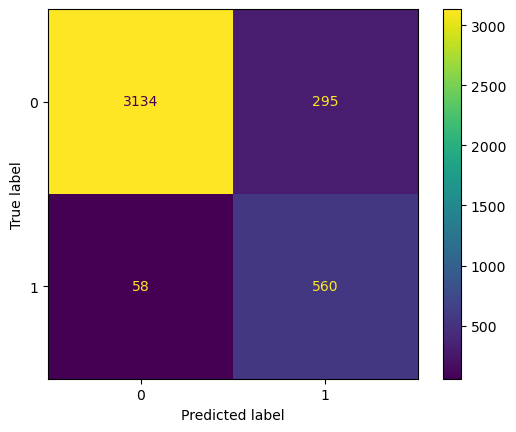

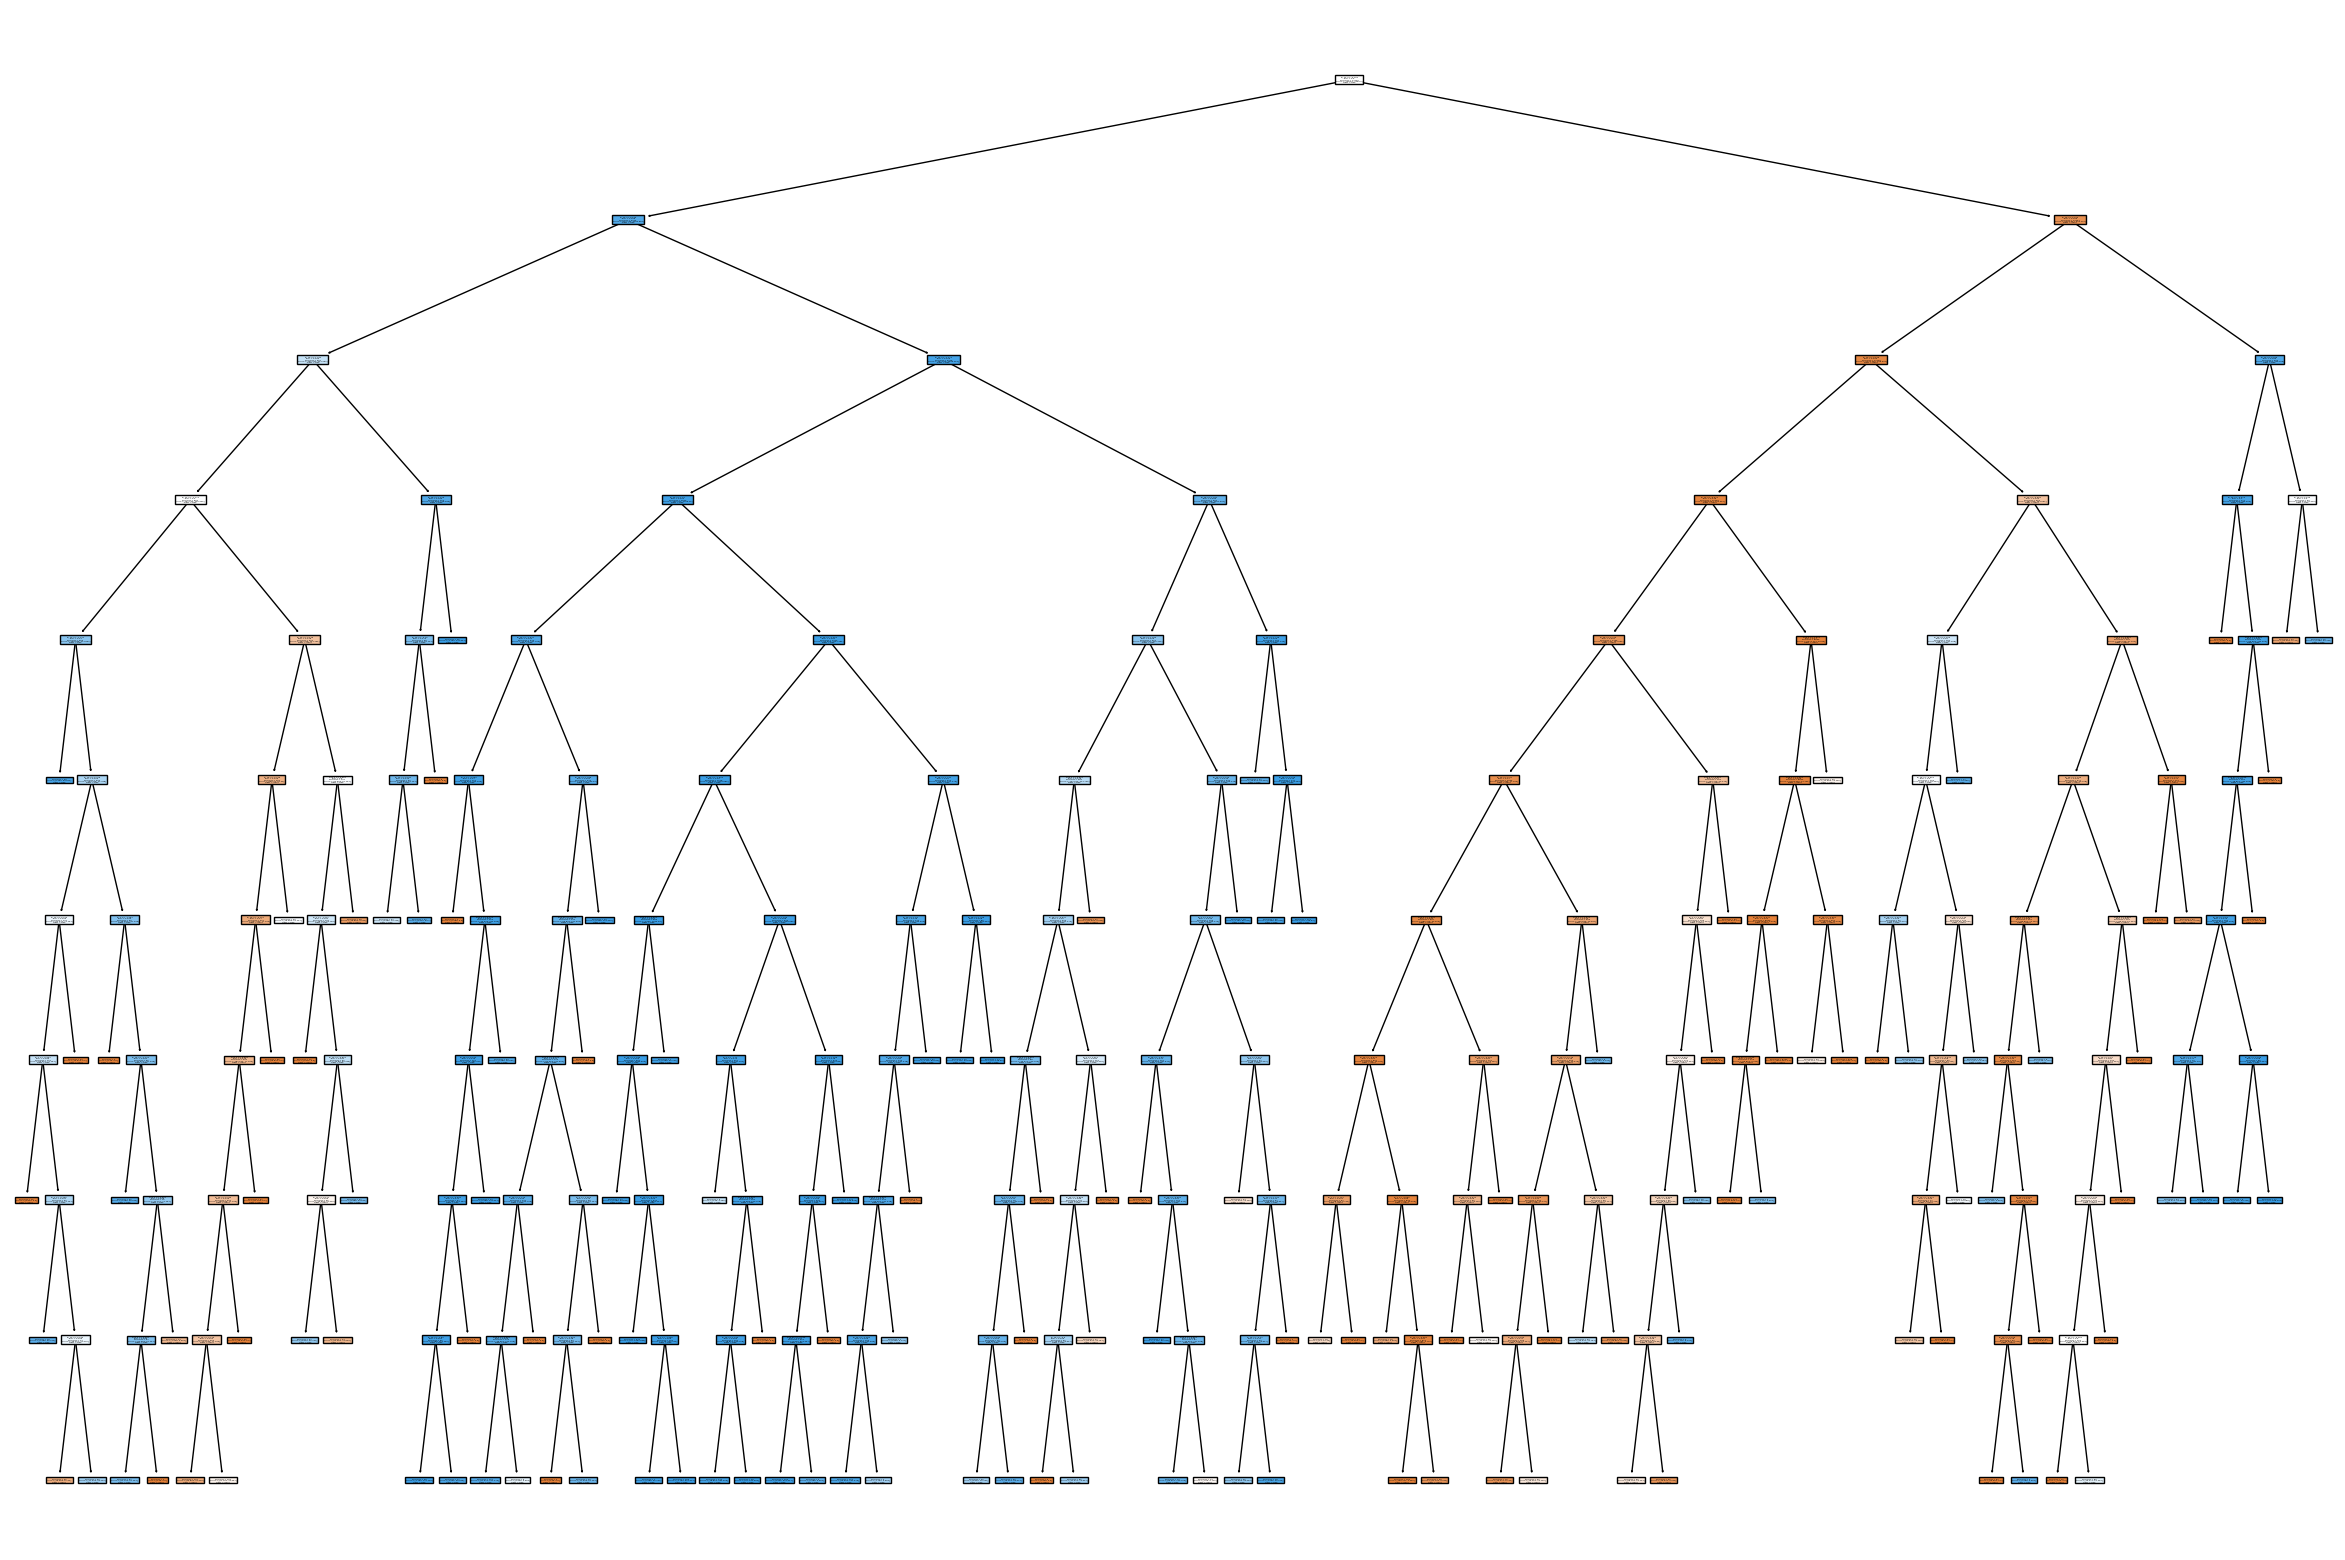

In [184]:
p = {
    "max_depth":10,
    "min_samples_split":50,
#     "min_samples_leaf":30,
#     "ccp_alpha":0.001,
    "class_weight":"balanced"
}
clf = get_classification_analysis_dt(p)
plot = tree_viz(clf)

In [182]:
plot.savefig("third_tree.png")

The decision tree that leverages pruning is able to generalize the model in a better way than the trees having no pruning. Due to this, the number of false negatives decreases. However, using pruning increases the number of false positives. An ideal model will have least number of false positives as well as false negatives. False positive means that the classifier falsely predicted that a furnace requires maintenance. This error can result in waste of time and money of an organization. False negative means that the classifier is predicts that maintenance is not required, however, it was not true. This misclassification shall have repurcussions too, as discussed in the introduction section. 

Hence we would be choosing the model which has least number of false positives and false negatives, that is, the model with overall highest F-1 scores for both the classes. The decision tree with following parameters performs the best in this respect:

"max_depth":10
"min_samples_split":50
"min_samples_leaf":30,
"ccp_alpha":0.001,
"class_weight":"balanced"
    
This decision tree can predict if a furnace requires maintenance with 94% recall.

Naive Bayes Classifier

In [193]:
numerical_cols = list(df.columns[:4].values)
categorical_cols = list(df.columns[4:].values)

Confusion Matrix:
[[3255  174]
 [  63  555]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3429
           1       0.76      0.90      0.82       618

    accuracy                           0.94      4047
   macro avg       0.87      0.92      0.89      4047
weighted avg       0.95      0.94      0.94      4047



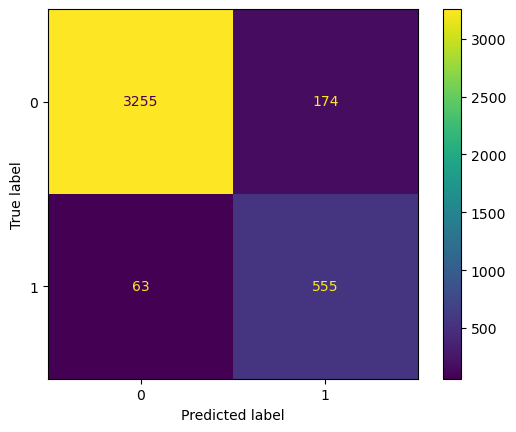

In [237]:
clf_gnb = GaussianNB()
# clf.set_params(**params)
clf_gnb.fit(X_train[:,:4], y_train)
y_pred_gnb = clf_gnb.predict(X_test[:,:4])
cm = confusion_matrix(y_test, y_pred_gnb)
cr = classification_report(y_test, y_pred_gnb)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=clf_gnb.classes_)
disp.plot()

Confusion Matrix:
[[3356   73]
 [ 348  270]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3429
           1       0.79      0.44      0.56       618

    accuracy                           0.90      4047
   macro avg       0.85      0.71      0.75      4047
weighted avg       0.89      0.90      0.88      4047



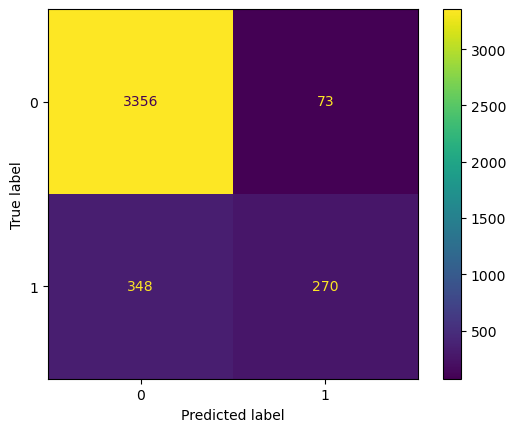

In [238]:
X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(df[categorical_cols],Label,test_size=0.2, random_state=42)
X_train_mnb, X_val_mnb, y_train_mnb, y_val_mnb = train_test_split(X_train_mnb, y_train_mnb, test_size=0.1, random_state=42)

clf_mnb = MultinomialNB()
# clf.set_params(**params)
clf_mnb.fit(X_train_mnb, y_train_mnb)
y_pred_mnb = clf_mnb.predict(X_test_mnb)
cm = confusion_matrix(y_test_mnb, y_pred_mnb)
cr = classification_report(y_test_mnb, y_pred_mnb)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=clf_mnb.classes_)
disp.plot()

In [210]:
clf_gnb.class_prior_

array([0.85102293, 0.14897707])

In [212]:
np.exp(clf_mnb.class_log_prior_)

array([0.85102293, 0.14897707])

In [224]:
test_final = np.concatenate((X_test[:,:4],X_test_mnb),axis=1)

print(test_final.shape)

pred2 = clf_gnb.predict_log_proba(X_test[:,:4])

pred1 = clf_mnb.predict_log_proba(X_test_mnb)

n = len(df.columns)

(4047, 14)


In [218]:
X_test_mnb.to_numpy()

(4047, 10)

In [219]:
X_test[:,:4]

(4047, 4)

In [225]:
#jll - sum of log probability of continuous and categorical data

log_prior = clf_mnb.class_log_prior_
jlls = []
jlls.append(clf_gnb._joint_log_likelihood(test_final[:,:4]))
jlls.append(clf_mnb._joint_log_likelihood(test_final[:,4:]))

jlls = np.hstack([jlls])

jlls = jlls - log_prior
jll = jlls.sum(axis=0) + log_prior


In [226]:
fo = np.exp(jll)
sumso = np.sum(fo, axis = 1, keepdims = True) 
result = fo/sumso

In [227]:
y_pred = np.argmax(result,axis=1)

In [228]:
y_pred

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3429
           1       0.73      0.91      0.81       618

    accuracy                           0.94      4047
   macro avg       0.86      0.93      0.89      4047
weighted avg       0.95      0.94      0.94      4047



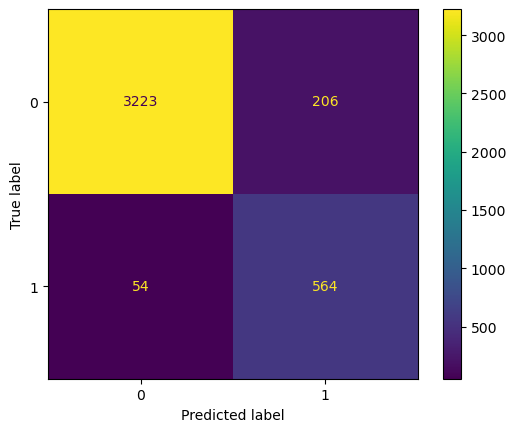

In [234]:
cm = confusion_matrix(y_test_mnb.astype(int), y_pred)
cr = classification_report(y_test_mnb.astype(int), y_pred)
print(cr)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_mnb.classes_)
disp.plot()

In [236]:
jlls.shape

(2, 4047, 2)